In [54]:
%%capture
%pip install nbformat
%run utils.ipynb

In [55]:
# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super(VAE, self).compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [56]:
# Sampling layer for reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [57]:
# Encoder
encoder_inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [58]:
# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")

In [59]:
train_noise = sample_noise(x_train.shape)

In [60]:
noise_factor = 0.5
noisy_x_train = x_train + noise_factor * sample_noise(x_train.shape)
noisy_x_train = np.clip(noisy_x_train, 0., 1.)

In [61]:
noisy_x_test = x_test + noise_factor * sample_noise(x_test.shape)
noisy_x_test = np.clip(noisy_x_test, 0., 1.)

In [62]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# Train the VAE
vae.fit(noisy_x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 49s 101ms/step - loss: 56.2226 - reconstruction_loss: 12.0013 - kl_loss: 1.1903
Epoch 2/10
469/469 [==============================] - 48s 101ms/step - loss: 0.9987 - reconstruction_loss: 0.9749 - kl_loss: 5.6530e-04
Epoch 3/10
469/469 [==============================] - 48s 101ms/step - loss: 0.9146 - reconstruction_loss: 0.9065 - kl_loss: 7.8904e-05
Epoch 4/10
469/469 [==============================] - 48s 101ms/step - loss: 0.8886 - reconstruction_loss: 0.8818 - kl_loss: 5.3526e-05
Epoch 5/10
469/469 [==============================] - 48s 101ms/step - loss: 0.8823 - reconstruction_loss: 0.8732 - kl_loss: 8.0213e-05
Epoch 6/10
469/469 [==============================] - 47s 101ms/step - loss: 0.8684 - reconstruction_loss: 0.8692 - kl_loss: 2.1007e-04
Epoch 7/10
469/469 [==============================] - 47s 101ms/step - loss: 0.8690 - reconstruction_loss: 0.8671 - kl_loss: 3.6466e-04
Epoch 8/10
469/469 [==============================

313/313 [==============================] - 1s 3ms/step


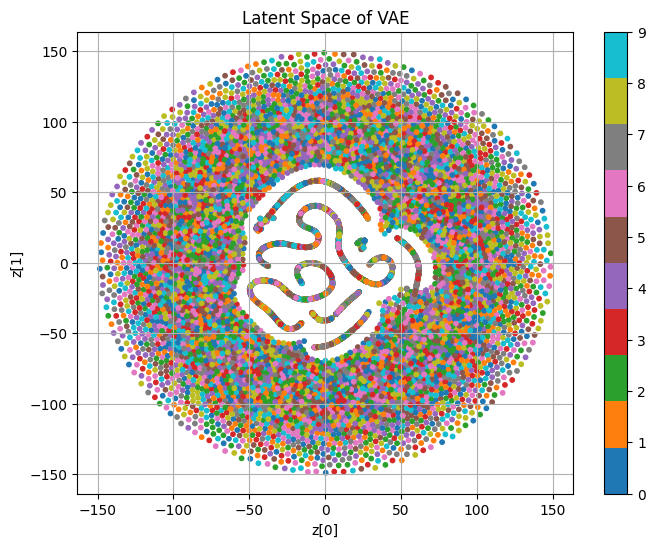

In [63]:
def plot_latent_space(model, data, labels):
    # Step 1: Encode data to latent space
    z_mean, _, _ = model.encoder.predict(data)

    # Step 2: Reduce to 2D if needed
    if z_mean.shape[1] > 2:
        z_2d = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(z_mean)
    else:
        z_2d = z_mean

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("Latent Space of VAE")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True)
    plt.show()

plot_latent_space(vae, noisy_x_test, y_test)

In [70]:
def plot_reconstruction(model, n=10, mean = 5.0, var = 'VAE'):
    if var == 'VAE':
        z_mean, z_log_var, _ = model.encoder.predict(x_test)
        latent_dim = z_mean.shape[1]
        scale = np.sqrt(np.mean(np.exp(z_log_var), axis=0))
    else:
        latent_dim = model.encoder.predict(x_test)[0].shape[1]
        scale = np.sqrt(var)
    # Sample from N(mean=5, std=√var) per latent dim
    noise = np.random.normal(
        loc=mean,
        scale=scale,
        size=(n, latent_dim)
    )

    # Decode noise to generate images
    generated_imgs = model.decoder.predict(noise)

    # Plot generated images
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_imgs[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Generated Images from N({mean}, {var})")
    plt.show()

1/1 [==============================] - 0s 14ms/step


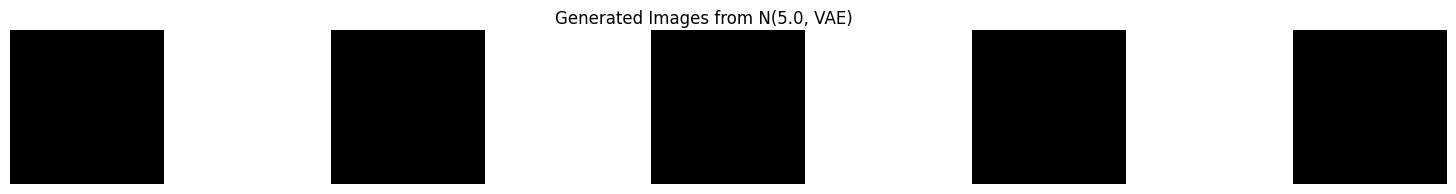

1/1 [==============================] - 0s 14ms/step


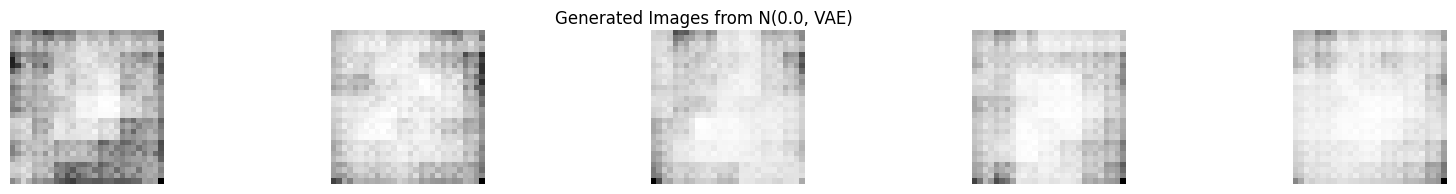

In [73]:
plot_reconstruction(vae, n=5, mean=5.0)
plot_reconstruction(vae, n=5, mean=0.0)